## 激光雷达圆孔扫描
- 汪星宇
- 2022年2月

### 1. 问题描述


### 2. 基本思路
1. 拟合平面，删除噪点
2. 分割线段，确定质心
3. 确定边界点，确定圆心和半径


### 3. 问题求解
#### 3.1 拟合平面，删除噪点
采用`RANSAC`方法拟合平面，open3d的内置算法`<pointcloud>.segment_plane`

>或者采用最小二乘方法拟合平面：
> https://blog.csdn.net/qq_36686437/article/details/117881459?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522164482097816780261993076%2522%252C%2522scm%2522%253A%252220140713.130102334.pc%255Fall.%2522%257D&request_id=164482097816780261993076&biz_id=0&utm_medium=distribute.pc_search_result.none-task-blog-2~all~first_rank_ecpm_v1~rank_v31_ecpm-3-117881459.pc_search_insert_es_download&utm_term=open3d%E7%9B%B4%E7%BA%BF%E6%8B%9F%E5%90%88&spm=1018.2226.3001.4187

In [33]:
import numpy as np
import open3d as o3d

points = np.loadtxt("../data/孔测试数据/20220214-2.txt", delimiter=',')
# points = np.loadtxt("../data/孔测试数据/1.txt", delimiter=',')
# 点云读取
source = o3d.geometry.PointCloud()
source.points = o3d.utility.Vector3dVector(points)

print("\n读取点云数据：", source)


读取点云数据： PointCloud with 16936 points.


In [34]:
# 计算平面方程
plane, inliers = source.segment_plane(distance_threshold=0.08, ransac_n=20, num_iterations=1000)

print(f"\n平面方程：{plane[0]:.2f}x + {plane[1]:.2f}y + {plane[2]:.2f}z + {plane[3]:.2f} =0")


平面方程：1.00x + -0.04y + 0.00z + -2197.22 =0


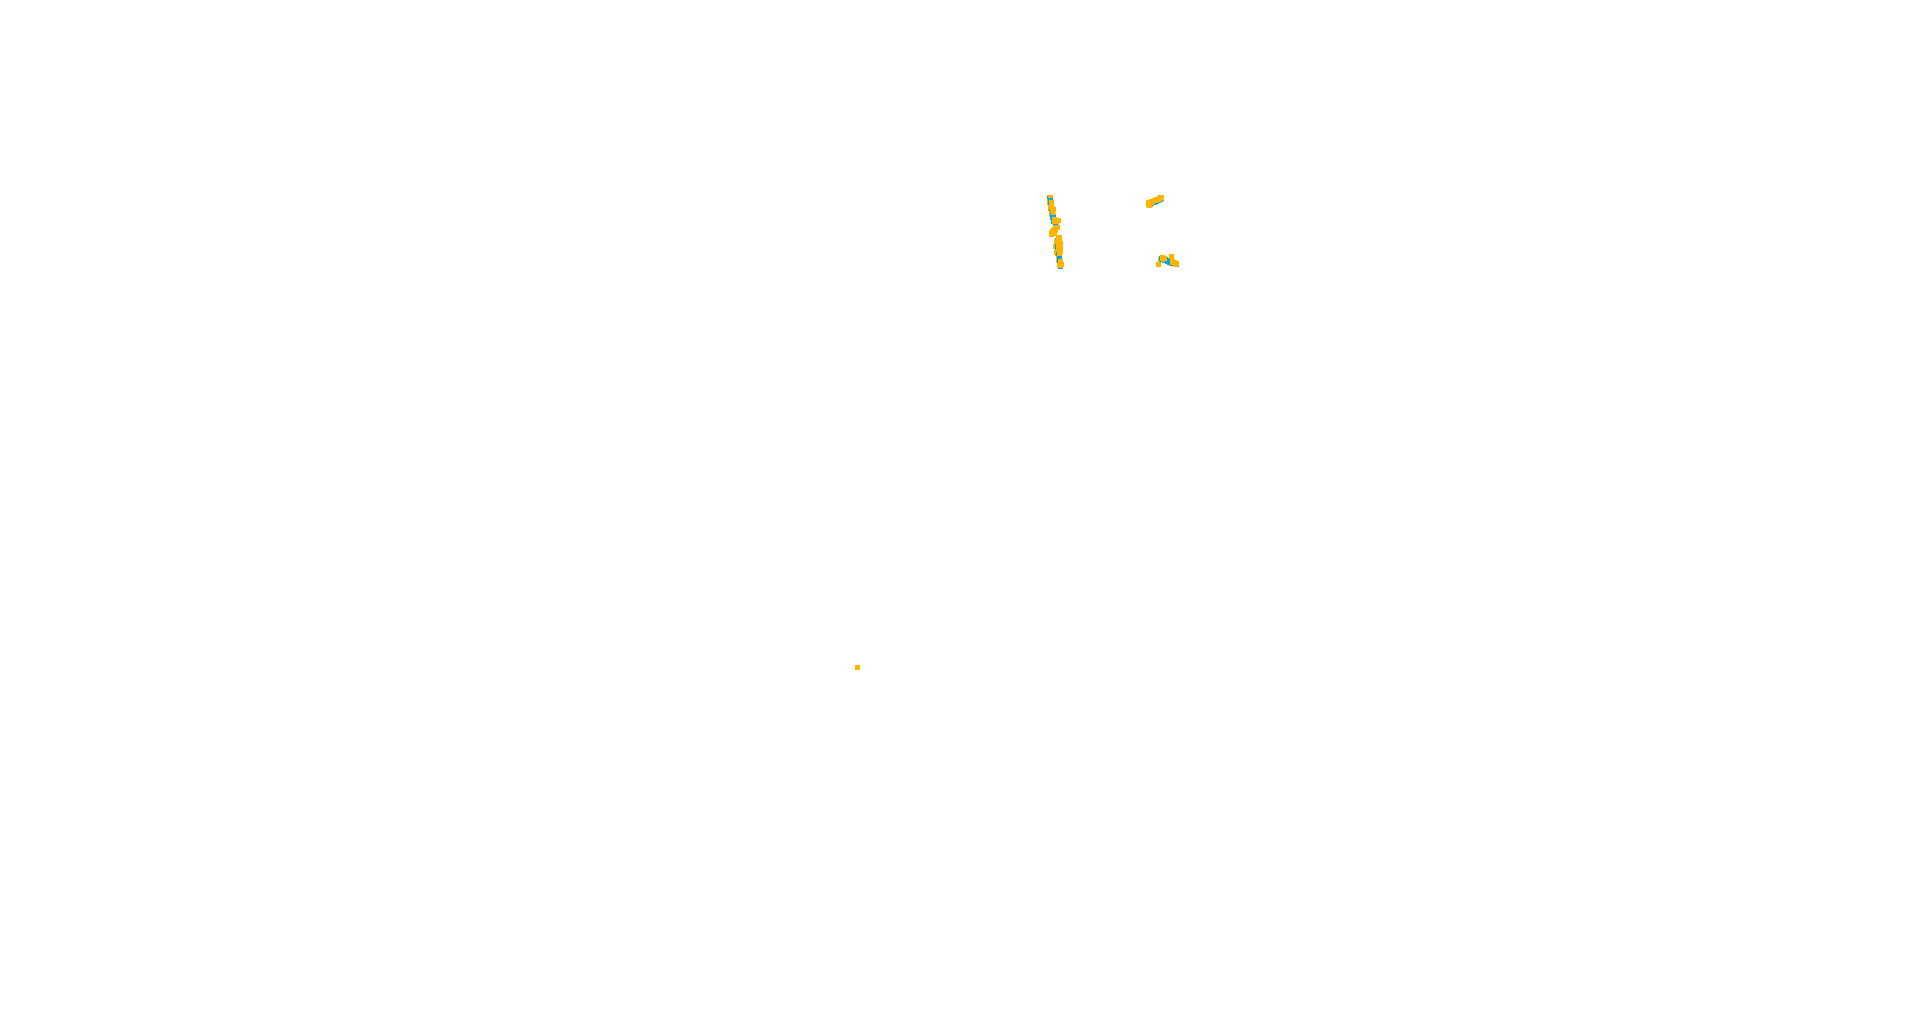

In [35]:
# 实现 notebook 行间显示功能
import open3d_tutorial

# 显示
inliers_points = source.select_by_index(inliers)
inliers_points.paint_uniform_color([0, 0.651, 0.929])
outliers_points = source.select_by_index(inliers, invert=True)
outliers_points.paint_uniform_color([1, 0.706, 0])
o3d.visualization.draw_geometries([inliers_points, outliers_points],window_name="原始点云")

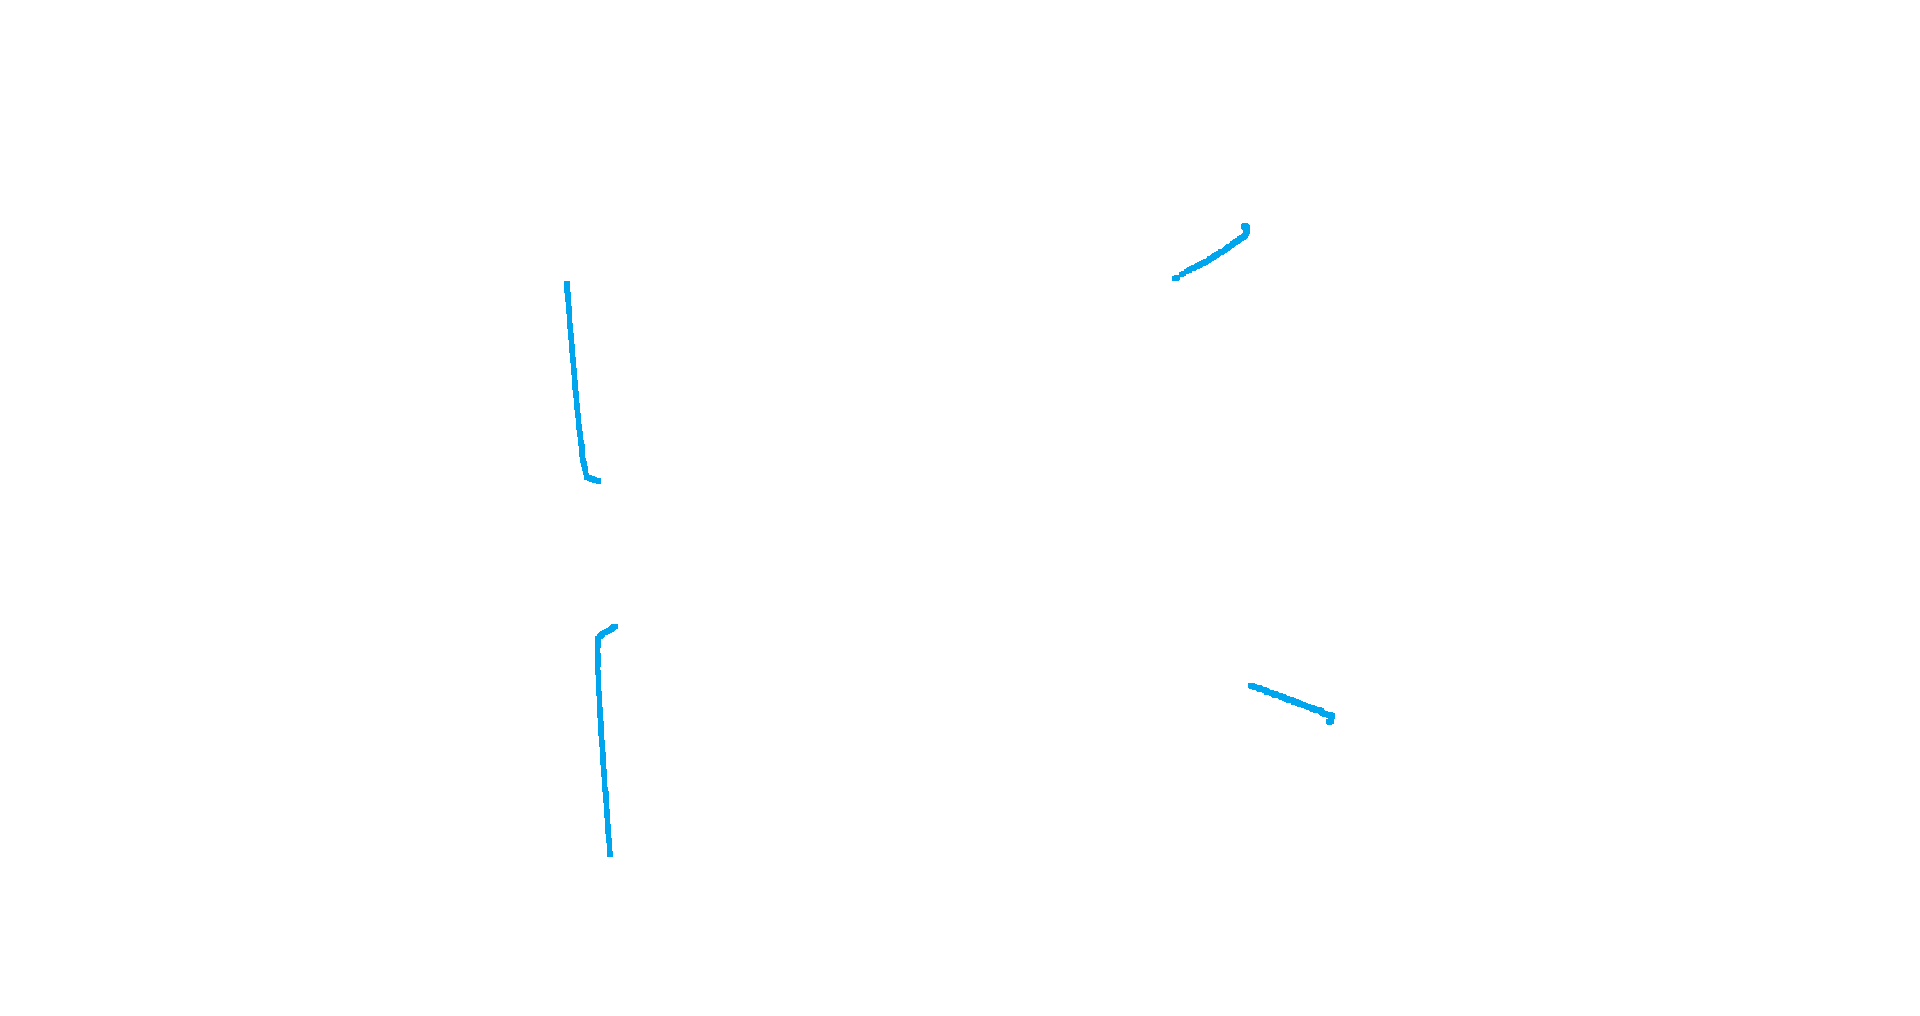

In [36]:
o3d.visualization.draw_geometries([inliers_points],window_name="平面去噪后点云")

#### 3.2 分割线段，确定质心

>https://zhuanlan.zhihu.com/p/462289333
> open3d聚类方法
>

[Open3D DEBUG] Precompute neighbors.
Clustering[========================================] 100%
[Open3D DEBUG] Done Precompute neighbors.                     ] 2%
[Open3D DEBUG] Compute Clusters
Precompute neighbors.[================>                       ] 37%                                  ] 5%
Precompute neighbors.[==============================>         ] 75%
点云有 4 簇

Precompute neighbors.[========================================] 100%


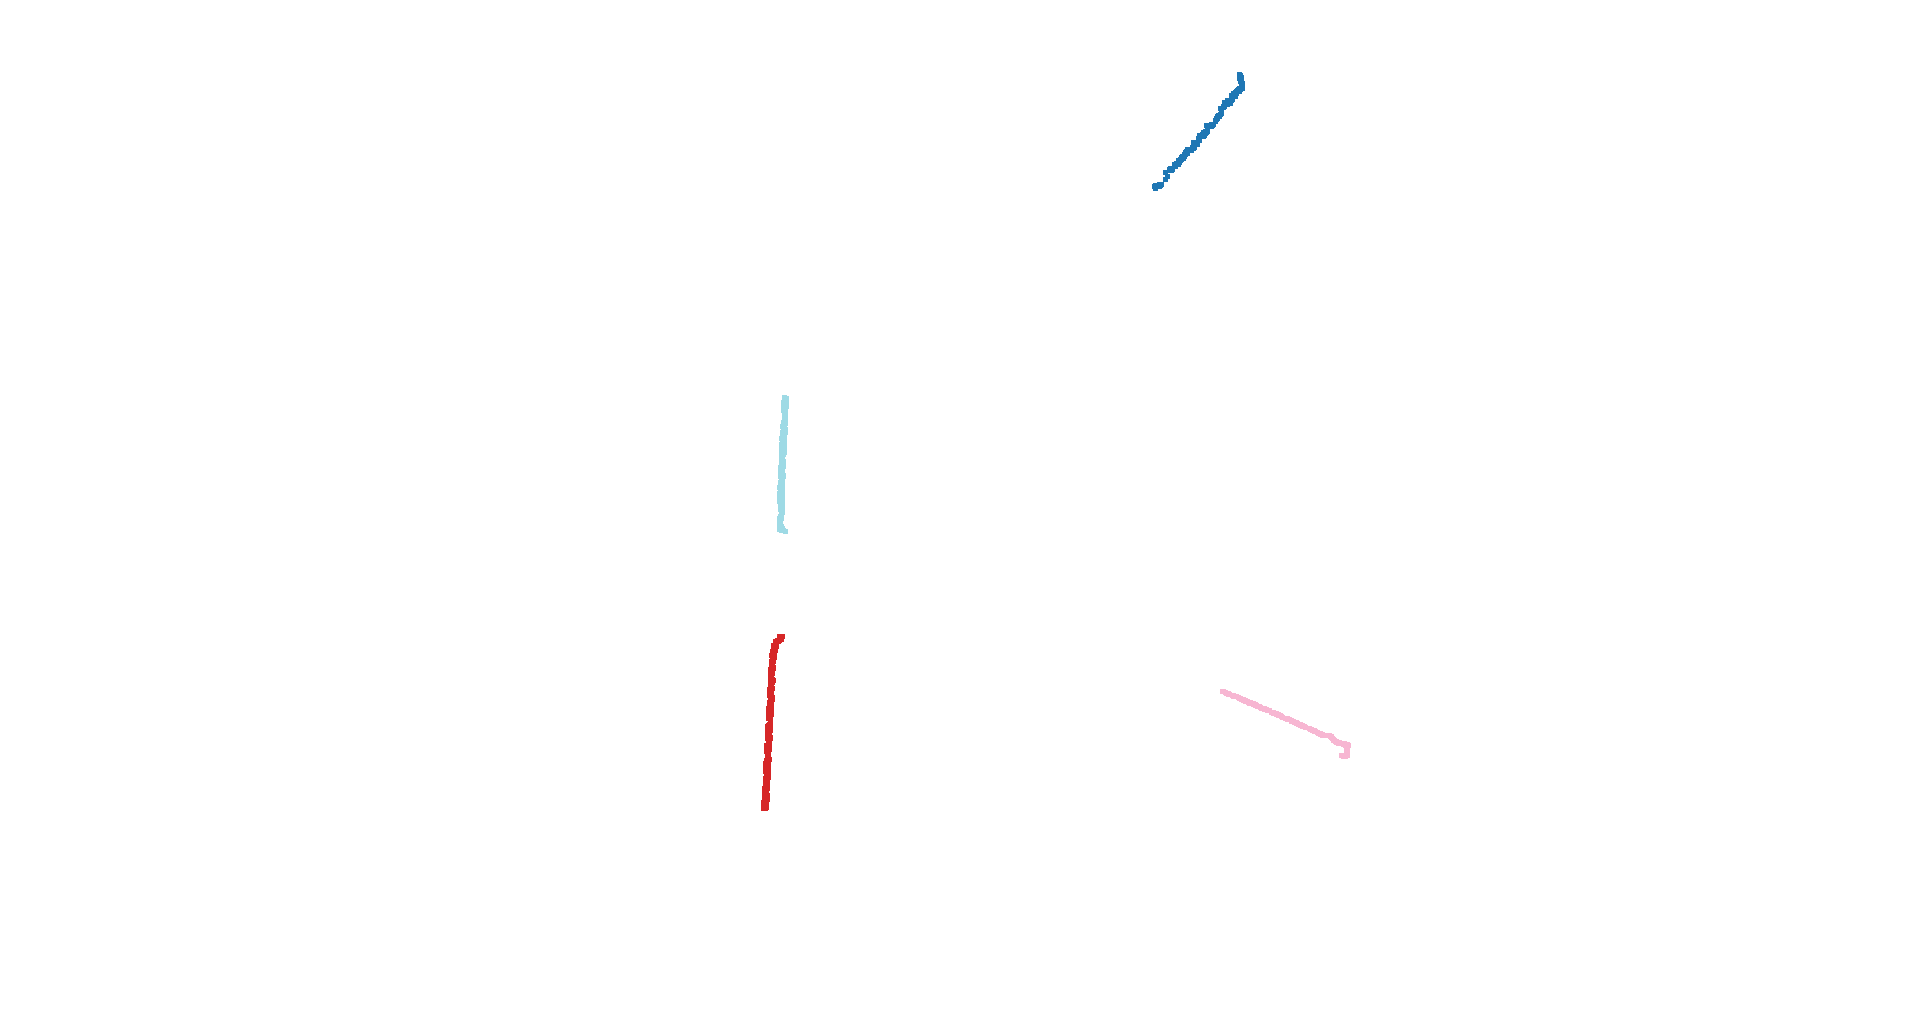

In [37]:
# 密度聚类
eps = 0.5  # 同一聚类中最大点间距
min_points = 50  # 有效聚类的最小点数
with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(inliers_points.cluster_dbscan(eps, min_points, print_progress=True))
max_label = labels.max()
print(f"\n点云有 {max_label + 1} 簇\n")  # label = -1 为噪声, 有效数据从 label=0 开始

# 显示聚类分割结果
import matplotlib.pyplot as plt
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0  # labels = -1 的簇为噪声，以黑色显示
inliers_points.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([inliers_points])


In [38]:
# 计算一团点云的质心
center = inliers_points.get_center().reshape((-1,3))
print("点云质心为：", center)


点云质心为： [[2188.20502402 -292.10350572 -556.48420044]]


#### 3.3 确定边界点，确定圆心和半径

按聚类的结果，对每一簇的点进行直线拟合，进一步去除扫描到孔内壁的杂散点。

In [67]:
##  由空间3维点拟合出一条直线

def linear_fitting_3D_points(points):
    '''
    该算法程序写得比较笨拙，而且针对的是无偏无噪的数据点拟合
    ----------------------------------------------------
    用直线拟合三维空间数据点, https://blog.csdn.net/qwertyu_1234567/article/details/117918602
    直线方程可以转化成如下形式：
    x = k1 * z + b1
    y = k2 * z + b2

    Input:
        points    ---   List， 三维空间数据点，例如：
                        [[2,3,48],[4,5,50],[5,7,51]]

    返回值是公式系数 k1, b1, k2, b2
    '''

    # 表示矩阵中的值
    Sum_X=0.0
    Sum_Y=0.0
    Sum_Z=0.0
    Sum_XZ=0.0
    Sum_YZ=0.0
    Sum_Z2=0.0

    for i in range(0,len(points)):
        xi=points[i][0]
        yi=points[i][1]
        zi=points[i][2]

        Sum_X = Sum_X + xi
        Sum_Y = Sum_Y + yi
        Sum_Z = Sum_Z + zi
        Sum_XZ = Sum_XZ + xi*zi
        Sum_YZ = Sum_YZ + yi*zi
        Sum_Z2 = Sum_Z2 + zi**2

    n = len(points) # 点数
    den = n*Sum_Z2 - Sum_Z * Sum_Z # 公式分母
    k1 = (n*Sum_XZ - Sum_X * Sum_Z)/ den
    b1 = (Sum_X - k1 * Sum_Z)/n
    k2 = (n*Sum_YZ - Sum_Y * Sum_Z)/ den
    b2 = (Sum_Y - k2 * Sum_Z)/n

    return k1, b1, k2, b2

def LinearFilter(cloudpoints):

    # 拟合直线
    points = np.asarray(cloudpoints.points)
    print("该簇点云数量为：", len(points))
    params = linear_fitting_3D_points(points)

    """
    计算点到拟合直线的距离
    https://blog.csdn.net/qq_32867925/article/details/114282835
    https://mathworld.wolfram.com/Point-LineDistance3-Dimensional.html
    """
    z = 1
    X1 = np.array([params[0]+params[1], params[2]+params[3], 1])
    X2 = np.array([params[1], params[3], 0])
    # distances = np.zeros((points.shape[0],1))
    distances = np.empty(len(points))
    for i in range(len(points)):
        distances[i] = np.linalg.norm(np.cross(points[i]-X1, points[i]-X2)) / np.linalg.norm(X2-X1)

    # std_distances = np.std(distances)
    # temp = np.argwhere((distances>distances-1*std_distances)&(distances<distances+1*std_distances))
    temp = np.argwhere(distances<0.2)
    inliers_points = cloudpoints.select_by_index(temp)
    inliers_points.paint_uniform_color([0, 0.651, 0.929])
    outliers_points = cloudpoints.select_by_index(temp, invert=True)
    outliers_points.paint_uniform_color([1, 0.706, 0])

    A = np.array([params[0], params[2], 1])
    A = A / np.linalg.norm(A)
    B = np.array([np.mean(points[:,0]), np.mean(points[:,1]), np.mean(points[:,2])])

    # -------------------------
    u = [0, 0, 1]
    v = A
    # Lets find a vector which is ortogonal to both u and v
    w = np.cross(u, v)

    # This orthogonal vector w has some interesting proprieties
    # |w| = sin of the required rotation
    # dot product of w and goal_normal_plane is the cos of the angle
    c = np.dot(u, v)
    s = np.linalg.norm(w)

    # Now, we compute rotation matrix from rodrigues formula
    # https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula
    # https://math.stackexchange.com/questions/180418/calculate-rotation-matrix-to-align-vector-a-to-vector-b-in-3d

    # We calculate the skew symetric matrix of the ort_vec
    Sx = np.asarray([[0, -w[2], w[1]], [w[2], 0, -w[0]], [-w[1], w[0], 0]])
    R = np.eye(3) + Sx + Sx.dot(Sx) * ((1 - c) / (s ** 2))
    #---------------------


    mesh_cylinder = o3d.geometry.TriangleMesh.create_cylinder(radius=0.05, height=10)
    mesh_cylinder.compute_vertex_normals()
    mesh_cylinder.paint_uniform_color([1, 0, 0])
    mesh_cylinder = mesh_cylinder.rotate(R, center=[0, 0, 0])
    mesh_cylinder = mesh_cylinder.translate((B[0], B[1], B[2]))

    o3d.visualization.draw_geometries([outliers_points, inliers_points, mesh_cylinder],window_name="直线拟合滤波")

    return inliers_points


def line_fit(pts, thresh=0.2, maxIteration=1000, sample = 4):
    """
    Find the best equation for the 3D line. The line in a 3d enviroment is defined as y = Ax+B, but A and B are vectors intead of scalars.

    :param pts: 3D point cloud as a `np.array (N,3)`.
    :param thresh: Threshold distance from the line which is considered inlier.
    :param maxIteration: Number of maximum iteration which RANSAC will loop over.
    :returns:
    - `A`: 3D slope of the line (angle) `np.array (1, 3)`
    - `B`: Axis interception as `np.array (1, 3)`
    - `inliers`: Inlier's index from the original point cloud. `np.array (1, M)`
    ---
    """
    n_points = pts.shape[0]
    best_inliers = []

    for it in range(2):

        # Samples 2 random points
        np.random.seed(it)
        id_samples = np.random.choice(range(int(n_points*0.3), int(n_points*0.7)), sample)
        pt_samples = pts[id_samples]
        one = np.mean(pt_samples[:sample//2, :], axis=0).reshape((1, 3))
        two = np.mean(pt_samples[:sample//2, :], axis=0).reshape((1, 3))

        # pt_samples = np.concatenate((one, two), axis=0)

        # The line defined by two points is defined as P2 - P1
        vecA = pt_samples[1, :] - pt_samples[0, :]
        vecA_norm = vecA / np.linalg.norm(vecA)

        # Distance from a point to a line
        pt_id_inliers = []  # list of inliers ids
        vecC_stakado = np.stack([vecA_norm] * n_points, 0)
        dist_pt = np.cross(vecC_stakado, (pt_samples[0, :] - pts))
        dist_pt = np.linalg.norm(dist_pt, axis=1)

        # Select indexes where distance is biggers than the threshold
        pt_id_inliers = np.where(np.abs(dist_pt) <= thresh)[0]

        if len(pt_id_inliers) > len(best_inliers):
            print("更新一次")
            best_inliers = pt_id_inliers
            inliers = best_inliers
            A = vecA_norm
            B = pt_samples[0, :]

    return A, B, inliers



import pyransac3d as pyrsc
def LineFilter(cloudpoints):
    points = np.asarray(cloudpoints.points)
    line = pyrsc.Line()

    # A:直线的斜率，B：直线的截距，inliers：内点索引，
    # thresh：内点的距离阈值
    # maxIteration：RANSAC算法的拟合次数
    # A, B, inliers = line.fit(points, thresh=0.05, maxIteration=1000)
    A, B, inliers = line_fit(points, thresh=0.2, maxIteration=1000)

    print(A, B)
    print('直线的三维斜率为：', A)
    print('直线的截距为：', B)

    R = pyrsc.get_rotationMatrix_from_vectors([0, 0, 1], A)
    ransac_line = cloudpoints.select_by_index(inliers)
    outlier_points = cloudpoints.select_by_index(inliers, invert=True)
    outlier_points.paint_uniform_color([0,0,0])
    mesh_cylinder = o3d.geometry.TriangleMesh.create_cylinder(radius=0.05, height=10)
    mesh_cylinder.compute_vertex_normals()
    mesh_cylinder.paint_uniform_color([1, 0, 0])
    mesh_cylinder = mesh_cylinder.rotate(R, center=[0, 0, 0])
    mesh_cylinder = mesh_cylinder.translate((B[0], B[1], B[2]))
    o3d.visualization.draw_geometries([outlier_points, ransac_line, mesh_cylinder])
    return ransac_line


In [68]:
def ClosestPoint(A, points):
    """
    返回points中最接近A点的点云点
    :param A:
    :param points:
    :return:
    """
    temp = o3d.geometry.PointCloud()
    temp.points = o3d.utility.Vector3dVector(A)
    # 计算到A点距离
    dists = np.asarray(points.compute_point_cloud_distance(temp))
    print("距离为", dists)
    return np.argmin(dists)

edge_points = []
# 按分割结果计算离质心最近点云
for i in range(0,max_label+1):
    index = np.argwhere(labels == i)
    # 第i块聚类
    cluster_i = inliers_points.select_by_index(index)
    # 拟合直线，进一步滤波
    temp = LineFilter(cluster_i)
    edge_points.append(cluster_i.points[ClosestPoint(center, cluster_i)])

edge_points = np.asarray(edge_points)
print("圆孔边缘点坐标",edge_points)


/tmp/ipykernel_3438/1797958502.py:142: RuntimeWarning: invalid value encountered in true_divide
  vecA_norm = vecA / np.linalg.norm(vecA)


UnboundLocalError: local variable 'A' referenced before assignment

In [ ]:
# # 利用最小二乘求解圆(球)方程（求出来是一个巨大的球，需要与平面相截）
# # 参考 https://zhuanlan.zhihu.com/p/97036816

#
# x = edge_points[:, 0]
# y = edge_points[:, 1]
# z = edge_points[:, 2]
# # print(x.size)
#
# A = np.asarray([-2*x, -2*y, -2*z, 0*x+1])
# B = -1*x**2 - y**2 - z**2
#
# X=np.linalg.lstsq(A, B, rcond = -1)
# print("\n方程的解为：",X[0])
#
# a = X[0][0]
# b = X[0][1]
# c = X[0][2]
# r = (a**2+b**2+c**2-X[0][3])**0.5
#
# print(f"\n圆(球)方程为：(x-{a:.2f})^2 + (y-{b:.2f})^2 + (z-{c:.2f})^2 = {r:.2f}^2")


利用圆孔边缘点，进行空间中圆的拟合

In [ ]:
# 参考资料： https://blog.csdn.net/weixin_42946636/article/details/104873413?spm=1001.2014.3001.5502
class CircleTrace():
    def __init__(self, p):
        self.PlaneMatrix = np.zeros((3, 4))
        self.Circle2DMatrix = np.zeros((3, 4))
        self.PlaneParam = np.zeros((3, 1))  # 平面方程参数系数
        self.Circle2DParam = np.zeros((3, 1))
        self.TransforMatrix = np.eye(3)
        self.InitPoint = np.array([p[0][0], p[0][1], p[0][2]])
        self.Points = p.T.reshape((3,-1))
        self.length = len(p)
        self.angle = 0
        self.start2D = []  # 平面的起点
        self.end2D = []  # 平面的终点
        self.center2D = []  # 平面的中心
        self.center3D = []
        self.radius = None
        self.z = 0

    def SolveMatrix(self, M):
        # M是拟合矩阵 np.array类型 3行4列
        # Ax = b
        A = M[:, 0:3]
        b = M[:, 3]
        x = np.linalg.solve(A, b)
        return x

    def CalPlane(self):
        """
        计算平面参数
        :return:
        """
        if self.length < 3:
            return
        x = np.array(self.Points[0])
        y = np.array(self.Points[1])
        z = np.array(self.Points[2])
        f = -np.ones((self.length, 1))
        xx = np.matmul(x, x.transpose())
        xy = np.matmul(x, y.transpose())
        xz = np.matmul(x, z.transpose())
        yy = np.matmul(y, y.transpose())
        yz = np.matmul(y, z.transpose())
        zz = np.matmul(z, z.transpose())
        xf = np.matmul(x, f)
        xf = xf[0]
        yf = np.matmul(y, f)
        yf = yf[0]
        zf = np.matmul(z, f)
        zf = zf[0]
        self.PlaneMatrix = np.array([[xx, xy, xz, xf],
                                     [xy, yy, yz, yf],
                                     [xz, yz, zz, zf]])
        self.PlaneParam = self.SolveMatrix(self.PlaneMatrix)

    def Project2Plane(self, p):
        """
        把点投影到平面 p为输入 array型 输出也为array型
        :param p:
        :return: q 为平面上的点坐标
        """
        k = -(np.dot(self.PlaneParam, p) + 1) / np.dot(self.PlaneParam, self.PlaneParam)
        q = k * self.PlaneParam + p
        return q

    def Transformation(self):
        """
        坐标变换  M 为平面到空间的变换矩阵
        :return:
        """
        n = self.PlaneParam / np.linalg.norm(self.PlaneParam)
        p = np.array([0, 0, 0])
        # 取第一个点为初始点
        m = self.Project2Plane(p) - self.Project2Plane(self.InitPoint)
        m = m / np.linalg.norm(m)
        mn = np.cross(m, n)  # m n 叉乘结果
        M = np.vstack((m, mn, n))
        self.TransforMatrix = M  # np.transpose(M)

    def CalCircle(self):
        """
        计算圆方程
        :return:
        """
        if self.length < 3:
            return
        self.CalPlane()
        self.Transformation()
        self.Circle2DParam = np.zeros((3, 1))
        projects = np.array(self.Points)
        projects = np.matmul(self.TransforMatrix, projects)
        self.start2D = [projects[0][0], projects[1][0]]
        self.end2D = [projects[0][self.length - 1], projects[1][self.length - 1]]
        # print("投影\n",projects)
        x, y = projects[0], projects[1]
        self.z = np.mean(projects[2])
        z = -np.ones((self.length, 1))
        f = x * x + y * y
        xx = np.matmul(x, x.transpose())
        xy = np.matmul(x, y.transpose())
        yy = np.matmul(y, y.transpose())
        xz, yz, zz = np.matmul(x, z), np.matmul(y, z), np.matmul(z.transpose(), z)
        xz, yz, zz = xz[0], yz[0], zz[0, 0]
        xf = np.matmul(x, f.transpose())
        yf = np.matmul(y, f.transpose())
        zf = np.matmul(f, z)
        zf = zf[0]
        self.Circle2DMatrix = np.array([[xx, xy, xz, xf],
                                        [xy, yy, yz, yf],
                                        [xz, yz, zz, zf]])
        # 计算圆方程的参数 A B C
        self.Circle2DParam = self.SolveMatrix(self.Circle2DMatrix)

    def Get2DCenterRadius(self):
        """
        获取圆方程的2D参数 a b r
        :return:
        """
        A, B, C = self.Circle2DParam[0], self.Circle2DParam[1], self.Circle2DParam[2]
        a, b = A / 2, B / 2
        r = np.sqrt(a * a + b * b - C)
        self.center2D = [a, b]
        self.radius = r
        return a, b, r

    def Get3DCenterRadiusNormal(self):
        """
        计算3D圆的圆心 半径 法向量
        :return:
        """
        # 获取3D方程参数
        self.Get2DCenterRadius()
        self.center3D = np.dot(cl.TransforMatrix.T, np.reshape([*self.center2D, self.z],(3, -1)))
        return self.center3D, self.radius, self.PlaneParam

    def Caculate(self):
        """
        计算求解
        :return:
        """
        if self.length < 3:
            return 0
        self.CalCircle()
        self.Get2DCenterRadius()
        self.Get3DCenterRadiusNormal()


In [ ]:
# 计算圆参数
cl = CircleTrace(edge_points)
cl.Caculate()

print("\n圆平面圆心:", cl.center2D)
print("\n空间圆心:", cl.center3D)
print("\n圆半径:", cl.radius)
print("\n点到平面的变换矩阵:", cl.TransforMatrix)

空间圆的可视化

In [ ]:
import open3d as o3d

# 绘制球体
mesh_sphere = o3d.geometry.TriangleMesh.create_sphere(radius=cl.radius,
                                                      resolution=100)
mesh_sphere.compute_vertex_normals()
mesh_sphere.paint_uniform_color([0.1, 0.8, 0.7])
# o3d.visualization.draw_geometries([mesh_sphere, inliers_points])

In [ ]:
sphere_vertices = np.asarray(mesh_sphere.vertices)
sphere_vertices[:,0] += cl.center3D[0][0]
sphere_vertices[:,1] += cl.center3D[1][0]
sphere_vertices[:,2] += cl.center3D[2][0]
mesh_sphere.vertices = o3d.utility.Vector3dVector(sphere_vertices)
o3d.visualization.draw_geometries([mesh_sphere, inliers_points])



空间直线拟合的一个例子

利用了`pyransac3d`这个python库


In [ ]:
# 测试用 例子


# https://blog.csdn.net/qq_36686437/article/details/120142814

import open3d as o3d
import numpy as np
import pyransac3d as pyrsc


points = np.asarray(cluster_i.points)

# ---------------------RANSAC拟合直线-------------------------------
print('进行RANSAC拟合直线，拟合结果为：')
line = pyrsc.Line()

# A:直线的斜率，B：直线的截距，inliers：内点索引，
# thresh：内点的距离阈值
# maxIteration：RANSAC算法的拟合次数
A, B, inliers = line.fit(points, thresh=0.05, maxIteration=500)
print('直线的三维斜率为：', A)
print('直线的截距为：', B)

R = pyrsc.get_rotationMatrix_from_vectors([0, 0, 1], A)
ransac_line = cluster_i.select_by_index(inliers)
outlier_line = cluster_i.select_by_index(inliers, invert=True)
outlier_line.paint_uniform_color([1, 1, 0])

mesh_cylinder = o3d.geometry.TriangleMesh.create_cylinder(radius=0.05, height=100)
mesh_cylinder.compute_vertex_normals()
mesh_cylinder.paint_uniform_color([1, 0, 0])
mesh_cylinder = mesh_cylinder.rotate(R, center=[0, 0, 0])
mesh_cylinder = mesh_cylinder.translate((B[0], B[1], B[2]))
o3d.visualization.draw_geometries([outlier_line, ransac_line, mesh_cylinder])





In [ ]:
# https://blog.csdn.net/qq_36686437/article/details/120142814

import open3d as o3d
import numpy as np
import pyransac3d as pyrsc

points = np.loadtxt("../data/孔测试数据/5.txt", delimiter=',')
# 点云读取
pcd_load = o3d.geometry.PointCloud()
pcd_load.points = o3d.utility.Vector3dVector(points)
pcd_load.paint_uniform_color([0, 0, 1])
print('获取输入数据的三维坐标')
points = np.asarray(pcd_load.points)

# ---------------------RANSAC拟合直线-------------------------------
print('进行RANSAC拟合直线，拟合结果为：')
line = pyrsc.Line()

# A:直线的斜率，B：直线的截距，inliers：内点索引，
# thresh：内点的距离阈值
# maxIteration：RANSAC算法的拟合次数
A, B, inliers = line.fit(points, thresh=0.02, maxIteration=500)
print('直线的三维斜率为：', A)
print('直线的截距为：', B)

R = pyrsc.get_rotationMatrix_from_vectors([0, 0, 1], A)
ransac_line = pcd_load.select_by_index(inliers)

mesh_cylinder = o3d.geometry.TriangleMesh.create_cylinder(radius=0.05, height=100)
mesh_cylinder.compute_vertex_normals()
mesh_cylinder.paint_uniform_color([1, 0, 0])
mesh_cylinder = mesh_cylinder.rotate(R, center=[0, 0, 0])
mesh_cylinder = mesh_cylinder.translate((B[0], B[1], B[2]))
o3d.visualization.draw_geometries([pcd_load, ransac_line, mesh_cylinder])
